# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [555]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
import time
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

In [556]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep = ';')

In [557]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



<AxesSubplot:>

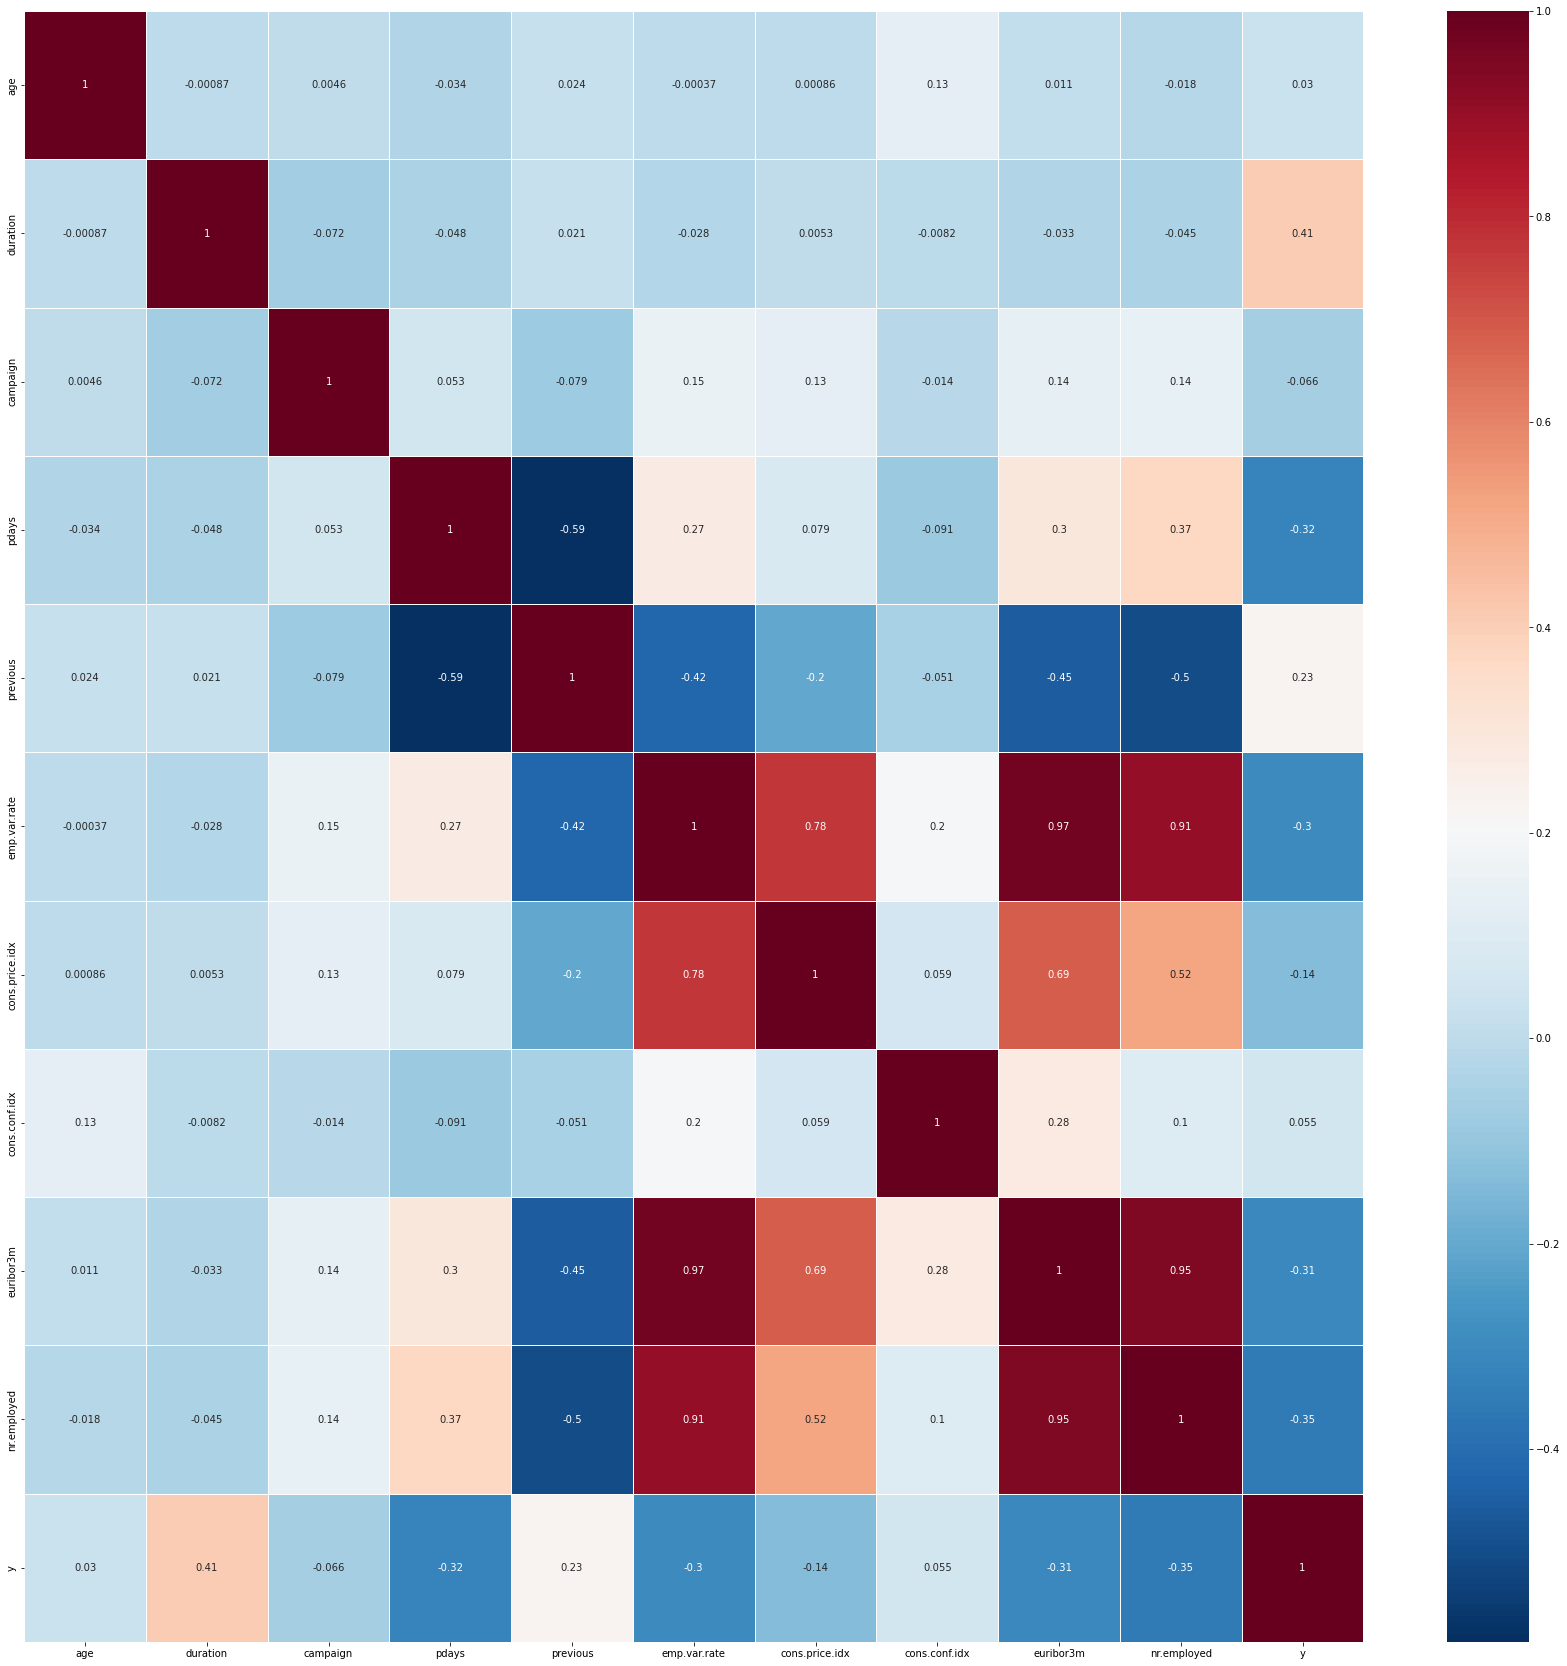

In [558]:
# correlation heat map to get a rough idea of the fetures to keep
df = df.replace({'y': {'yes': 1,'no': 0}})
corr=df.corr()
plt.figure(figsize = (30,30))
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [559]:
# Quick look at the correlations to 'y'
abs(corr['y']).sort_values(ascending=False)

y                 1.000000
duration          0.405274
nr.employed       0.354678
pdays             0.324914
euribor3m         0.307771
emp.var.rate      0.298334
previous          0.230181
cons.price.idx    0.136211
campaign          0.066357
cons.conf.idx     0.054878
age               0.030399
Name: y, dtype: float64

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [560]:
df_bank=df
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [561]:
#The data is imbalanced making it easy to predict 'no' and be correct. no=26781, yes= 3886
#The recall and precision scores will be the most telling measure.
#precision = From all of the positive class we predicted as 'yes', how many are actually 'yes'?
#recall = From all of the positive class, how many we predicted correctly.

#remove 'unknown' from data
df_bank=df_bank[df_bank['default']!= 'unknown']
df_bank=df_bank[df_bank['housing']!= 'unknown']
df_bank=df_bank[df_bank['loan']!= 'unknown']
df_bank=df_bank[df_bank['education']!= 'unknown']

#convert object data to binary 
df_bank = df_bank.replace({'default': {'yes': 1,'no': 0}})
df_bank = df_bank.replace({'housing': {'yes': 1,'no': 0}})
df_bank = df_bank.replace({'loan': {'yes': 1,'no': 0}})

#Change object 'education' data to ordinal 
enc = OrdinalEncoder(categories = [['illiterate','basic.4y', 'basic.6y','basic.9y','high.school', 'professional.course','university.degree']])
df_bank['education']= enc.fit_transform(df_bank[['education']])

#Change nominal/catagorical data to numeric    
df_bank = pd.get_dummies(df_bank, columns=['job','marital', 'month', 'day_of_week'] )



In [563]:
#What 10 best features did we use for Logistic Regression
cols = list(X_train.columns)
model = LogisticRegression()
rfe = RFE(model, 10)             
X_rfe = rfe.fit_transform(X_train,y_train)  
model.fit(X_rfe,y_train)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print('10 best selected featurs for Logistic Regression',selected_features_rfe)

#What 10 best features did we use for DecisionTree Classifier
model = DecisionTreeClassifier()
rfe = RFE(model, 10)             
X_rfe = rfe.fit_transform(X_train,y_train)  
model.fit(X_rfe,y_train)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print('10 best selected featurs for Decision Tree',selected_features_rfe)

# Not much help since they both used different features

10 best selected featurs for Logistic Regression Index(['previous', 'emp.var.rate', 'job_retired', 'job_student', 'month_apr',
       'month_mar', 'month_may', 'month_nov', 'month_sep', 'day_of_week_mon'],
      dtype='object')
10 best selected featurs for Decision Tree Index(['age', 'education', 'housing', 'duration', 'campaign', 'previous',
       'emp.var.rate', 'cons.conf.idx', 'marital_married', 'day_of_week_thu'],
      dtype='object')


In [564]:
#Lets look at the df_bankcorrelations  now that all of the data has been transfomed where needed
corr=df_bank.corr()
cor_target = abs(corr["y"])
relevant_features = cor_target[cor_target>0.1]
relevant_features

duration          0.394254
pdays             0.325933
previous          0.228206
emp.var.rate      0.305049
cons.price.idx    0.128968
euribor3m         0.315522
nr.employed       0.363606
y                 1.000000
job_retired       0.102017
month_mar         0.146073
month_may         0.113197
month_oct         0.140435
month_sep         0.123232
Name: y, dtype: float64

In [565]:
#Check for correlated columns that can be removed.
print(df_bank[['duration','pdays','previous','emp.var.rate','cons.price.idx',
               'euribor3m','nr.employed','job_retired','month_mar', 'month_may','month_oct','month_sep']].corr())

                duration     pdays  previous  emp.var.rate  cons.price.idx  \
duration        1.000000 -0.046155  0.019306     -0.022891        0.012845   
pdays          -0.046155  1.000000 -0.590843      0.269607        0.068489   
previous        0.019306 -0.590843  1.000000     -0.404120       -0.177399   
emp.var.rate   -0.022891  0.269607 -0.404120      1.000000        0.766153   
cons.price.idx  0.012845  0.068489 -0.177399      0.766153        1.000000   
euribor3m      -0.028555  0.296111 -0.439384      0.969407        0.667437   
nr.employed    -0.039798  0.371717 -0.488779      0.900466        0.489148   
job_retired     0.014596 -0.079674  0.073454     -0.128505       -0.064564   
month_mar      -0.007285 -0.063876  0.059395     -0.136098       -0.095040   
month_may       0.001628  0.072945 -0.012495     -0.108109       -0.061698   
month_oct       0.017941 -0.120906  0.119852     -0.215082       -0.086288   
month_sep       0.014506 -0.147606  0.145957     -0.167267      

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [613]:
#Drop 'poutcome' - too many unknowns.
#Drop 'dpays' - too many were 999 -39673
#Drop contact_telephone   corr= 0.144249, contact_cellular corr=  0.144249
#Drop cons.price.idx  higly corr. with emp.var.rate
#Drop euribor3m higly corr. with emp.var.rate
#Drop nr.employed higly corr. with emp.var.rate
df_bank_X = df_bank.drop(columns=['poutcome', 'y', 'pdays', 'contact', 'cons.price.idx', 'euribor3m', 'nr.employed', 'duration'])
df_bank_y = df_bank['y']
df_bank_X
#Create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(df_bank_X, df_bank_y, test_size=0.5, random_state=42 )
#Smaller test size might make for more accurate results but will take longer to train.
X_train


,age,education,default,housing,loan,campaign,previous,emp.var.rate,cons.conf.idx,job_admin.,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
31657,38,5.0,0,1,0,2,1,-1.8,-46.2,0,...,0,1,0,0,0,0,0,1,0,0
7814,60,6.0,0,0,0,2,0,1.4,-41.8,0,...,0,0,0,0,0,0,1,0,0,0
750,30,3.0,0,0,1,2,0,1.1,-36.4,0,...,0,1,0,0,0,0,0,0,1,0
35374,27,6.0,0,1,0,3,0,-1.8,-46.2,0,...,0,1,0,0,0,1,0,0,0,0
20971,49,6.0,0,1,0,1,0,1.4,-36.1,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40215,48,5.0,0,0,0,1,1,-1.7,-40.3,0,...,0,0,0,0,0,0,0,0,1,0
8434,33,3.0,0,0,0,2,0,1.4,-41.8,0,...,0,0,0,0,0,0,0,0,1,0
1407,45,6.0,0,0,0,2,0,1.1,-36.4,0,...,0,1,0,0,0,0,0,1,0,0
23427,37,5.0,0,1,0,2,0,1.4,-36.1,0,...,0,0,0,0,0,0,0,0,0,1


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [614]:
#Get data for baseline
print('True/False counts')
print(y_train.value_counts())
false=13398
true=1935
# Theoretical values if our model always chooses 0
tn=13398
tp=0
fn=1935
fp=13398

#Baseline our model should do better than just guessing the largest class 100% of the time. 
print('Baseline Accuracy =', 1- true/false)
print('Baseline Precision =', tp / (tp + fp))
print('Baseline Recall = ', tp / (tp + fn))
#True Positive / (True Positive + False Negative)
print()
print()
KNN_default = KNeighborsClassifier(n_neighbors=3)
start = time.time()
KNN_default.fit(X_train, y_train)
stop = time.time()
KNN_time=stop-start
y_pred_KNN_default =KNN_default.predict(X_test)
y_train_pred_KNN_default =KNN_default.predict(X_train)

print('Test Model scores')
print('Accuracy Score - KNN - Default:', metrics.accuracy_score(y_test, y_pred_KNN_default))
print('Accuracy Score - train - KNN - Default:', metrics.accuracy_score(y_train, y_train_pred_KNN_default))
print('Recall Score - train  - KNN - Default:', metrics.recall_score(y_test, y_pred_KNN_default)) 
print('Precision Score - train - KNN - Default:', metrics.precision_score(y_test, y_pred_KNN_default)) 

True/False counts
0    13398
1     1935
Name: y, dtype: int64
Baseline Accuracy = 0.8555754590237349
Baseline Precision = 0.0
Baseline Recall =  0.0


Test Model scores
Accuracy Score - KNN - Default: 0.8614190687361419
Accuracy Score - train - KNN - Default: 0.9155416422096132
Recall Score - train  - KNN - Default: 0.25986673500768837
Precision Score - train - KNN - Default: 0.42676767676767674


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [615]:
lr_default = LogisticRegression(max_iter=1000)
lr_pipe = Pipeline(steps=[("scaler", StandardScaler()), ("logistic", lr_default)])
start = time.time()
lr_pipe.fit(X_train, y_train)
stop = time.time()
y_pred_lr_default =lr_pipe.predict(X_test)
y_train_pred_lr_def =lr_pipe.predict(X_train)
lr_time=stop-start


### Problem 9: Score the Model

What is the accuracy of your model?

In [616]:
print('Recall - lr_default:', metrics.recall_score(y_test, y_pred_lr_default))
print('Precision - lr_default:', metrics.precision_score(y_test, y_pred_lr_default))
print('Accuracy Score - lr_default:', metrics.accuracy_score(y_test, y_pred_lr_default))


Recall - lr_default: 0.1255766273705792
Precision - lr_default: 0.46313799621928164
Accuracy Score - lr_default: 0.87022303378114


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [617]:
model_stats=pd.DataFrame()

In [618]:
df1=pd.DataFrame()
svc_default=svm.SVC()
start = time.time()
svc_default.fit(X_train, y_train)
stop = time.time()
y_pred_svc_default =svc_default.predict(X_test)
y_train_pred_svc_default =svc_default.predict(X_train)

df1['Model']=['svc']
df1['Train Time']= [stop-start]
df1['Training Accuracy'] = [metrics.accuracy_score(y_train, y_train_pred_svc_default)]
df1['Test Accuracy'] = [metrics.accuracy_score(y_test, y_pred_svc_default)]
df1['Test Recall']= [metrics.recall_score(y_test, y_pred_svc_default)]
df1['Test Precision']= [metrics.precision_score(y_test, y_pred_svc_default)]
model_stats=model_stats.append(df1)

In [619]:
dt_default = DecisionTreeClassifier(max_depth=2)
start = time.time()
dt_default.fit(X_train, y_train)
stop = time.time()
y_pred_dt_default =dt_default.predict(X_test)
y_train_pred_dt_default =dt_default.predict(X_train)

df1['Model']=['Decision Tree']
df1['Train Time']= [stop-start]
df1['Training Accuracy'] = [metrics.accuracy_score(y_train, y_train_pred_dt_default)]
df1['Test Accuracy'] = [metrics.accuracy_score(y_test, y_pred_dt_default)]
df1['Test Recall']= [metrics.recall_score(y_test, y_pred_svc_default)]
df1['Test Precision']= [metrics.precision_score(y_test, y_pred_dt_default)]
model_stats=model_stats.append(df1)


In [620]:
# already run model above
df1['Model']=['Logistic Regression']
df1['Train Time']= [lr_time]
df1['Training Accuracy'] = [metrics.accuracy_score(y_train, y_train_pred_lr_def)]
df1['Test Accuracy'] = [metrics.accuracy_score(y_test, y_pred_lr_default)]
df1['Test Recall']= [metrics.recall_score(y_test, y_pred_lr_default)]
df1['Test Precision']= [metrics.precision_score(y_test, y_pred_lr_default)]
model_stats=model_stats.append(df1)


In [621]:
# already run model above
df1['Model']=['KNN']
df1['Train Time']= [KNN_time]
df1['Training Accuracy'] = [metrics.accuracy_score(y_train, y_train_pred_KNN_default)]
df1['Test Accuracy'] = [metrics.accuracy_score(y_test, y_pred_KNN_default)]
df1['Test Recall']= [metrics.recall_score(y_test, y_pred_KNN_default)]
df1['Test Precision']= [metrics.precision_score(y_test, y_pred_KNN_default)]
model_stats=model_stats.append(df1)
model_stats

,Model,Train Time,Training Accuracy,Test Accuracy,Test Recall,Test Precision
0,svc,3.150460,0.873802,0.872766,0.000000,0.000000
0,Decision Tree,0.013964,0.874193,0.873614,0.000000,0.696970
0,Logistic Regression,0.036875,0.874389,0.870223,0.125577,0.463138
0,KNN,0.004086,0.915542,0.861419,0.259867,0.426768


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [622]:
gs_model_stats=pd.DataFrame()
df1=pd.DataFrame()
gs_model_stats

""


In [623]:
KNN_default = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
y_pred_KNN_default =KNN_default.predict(X_test)

estimator_KNN = KNeighborsClassifier(('scale', StandardScaler()),algorithm='auto')

parameters_KNN = {
    'n_neighbors': (1,2,3,4),
    'leaf_size': (1,5,10),
    'weights': ('uniform', 'distance')}
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5).fit(X_train, y_train)

knn_train_score = grid_search_KNN.score(X_train,y_train)
knn_test_score = grid_search_KNN.score(X_test,y_test)

print('Best Paramaters:' ,grid_search_KNN.best_params_) 
print('Best Score - KNN:', grid_search_KNN.best_score_ )

mean_fit_time= grid_search_KNN.cv_results_['mean_fit_time']
mean_score_time= grid_search_KNN.cv_results_['mean_score_time']
n_splits  = grid_search_KNN.n_splits_ #number of splits of training data
n_iter = pd.DataFrame(grid_search_KNN.cv_results_).shape[0] #Iterations per split
KNN_rt=np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter

KNN_1=grid_search_KNN.fit(X_train, y_train)
y_pred_KNN1 =KNN_1.predict(X_test)

Best Paramaters: {'leaf_size': 1, 'n_neighbors': 4, 'weights': 'uniform'}
Best Score - KNN: 0.8696268230863191


Run Time 415.2039840221405
Accuracy Score - KNN - Default: 0.8614190687361419
Accuracy Score - KNN - GridSearch: 0.8723751141254728
Precision - KNN: 0.49523809523809526
Recall - KNN: 0.15991799077396207
ROC Score - KNN: 0.5680782511592294


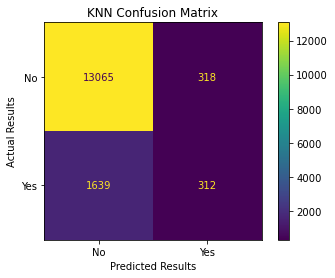

In [624]:

print('Run Time', KNN_rt)
print('Accuracy Score - KNN - Default:', metrics.accuracy_score(y_test, y_pred_KNN_default))  
print('Accuracy Score - KNN - GridSearch:', metrics.accuracy_score(y_test, y_pred_KNN1)) 
print('Precision - KNN:', metrics.precision_score(y_test, y_pred_KNN1)) 
print('Recall - KNN:', metrics.recall_score(y_test, y_pred_KNN1))
print('ROC Score - KNN:', roc_auc_score(y_test, y_pred_KNN1))

cm = confusion_matrix(y_test,y_pred_KNN1)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes'])
cmd_obj.plot()
cmd_obj.ax_.set(title='KNN Confusion Matrix', 
                xlabel='Predicted Results', 
                ylabel='Actual Results')
plt.show()

df1['Model']=['KNN']
df1['Train Time']= [KNN_rt]
df1['Test Accuracy'] = [metrics.accuracy_score(y_test, y_pred_KNN1)]
df1['Test Recall']= [metrics.recall_score(y_test, y_pred_KNN1)]
df1['Test Precision']= [metrics.precision_score(y_test, y_pred_KNN1)]
gs_model_stats=gs_model_stats.append(df1)


In [625]:
#pca = PCA()
estimator_lr = LogisticRegression(max_iter=1000,multi_class='auto')

parameters_lr = {"penalty":['none', 'l1', 'l2', 'elasticnet'],
                'solver': ['newton-cg', 'lbfgs', 'liblinear'],}
   
grid_search_lr = GridSearchCV(
    estimator=estimator_lr,
    param_grid=parameters_lr,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5).fit(X_train, y_train)

lr_train_score = grid_search_KNN.score(X_train,y_train)
lr_test_score = grid_search_KNN.score(X_test,y_test)

print('Best Paramaters:' ,grid_search_lr.best_params_) 
print('Best Score - KNN:', grid_search_lr.best_score_ )

mean_fit_time= grid_search_lr.cv_results_['mean_fit_time']
mean_score_time= grid_search_lr.cv_results_['mean_score_time']
n_splits  = grid_search_lr.n_splits_ #number of splits of training data
n_iter = pd.DataFrame(grid_search_lr.cv_results_).shape[0] #Iterations per split
lr_rt = np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter


lr1=grid_search_lr.fit(X_train, y_train)
y_pred_lr1 =grid_search_lr.predict(X_test)

print('Accuracy Score - lr - Default:', metrics.accuracy_score(y_test, y_pred_lr_default))  
print('Accuracy Score - lr - GridSearch:', metrics.accuracy_score(y_test, y_pred_lr1)) 

Best Paramaters: {'penalty': 'l2', 'solver': 'newton-cg'}
Best Score - KNN: 0.8723014664236063
Accuracy Score - lr - Default: 0.87022303378114
Accuracy Score - lr - GridSearch: 0.8702882483370288


Run Time 67.30590009689331
Accuracy Score - Log.Reg. - Default: 0.87022303378114
Accuracy Score - Log.Reg - GridSearch: 0.8702882483370288
Precision - Log.Reg: 0.4637404580152672
Recall - Log.Reg: 0.12455151204510508
ROC Score - Log.Reg: 0.5517773625382815


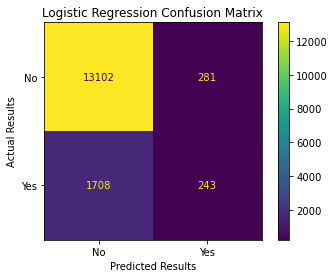

In [626]:
print('Run Time', lr_rt)
print('Accuracy Score - Log.Reg. - Default:', metrics.accuracy_score(y_test, y_pred_lr_default))  
print('Accuracy Score - Log.Reg - GridSearch:', metrics.accuracy_score(y_test, y_pred_lr1)) 
print('Precision - Log.Reg:', metrics.precision_score(y_test, y_pred_lr1)) 
print('Recall - Log.Reg:', metrics.recall_score(y_test, y_pred_lr1))
print('ROC Score - Log.Reg:', roc_auc_score(y_test, y_pred_lr1))

cm = confusion_matrix(y_test,y_pred_lr1)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes'])
cmd_obj.plot()
cmd_obj.ax_.set(title='Logistic Regression Confusion Matrix', 
                xlabel='Predicted Results', 
                ylabel='Actual Results')
plt.show()

df1['Model']=['Logistic Regression']
df1['Train Time']= [lr_rt]
df1['Test Accuracy'] = [metrics.accuracy_score(y_test, y_pred_lr1)]
df1['Test Recall']= [metrics.recall_score(y_test, y_pred_lr1)]
df1['Test Precision']= [metrics.precision_score(y_test, y_pred_lr1)]
gs_model_stats=gs_model_stats.append(df1)


In [627]:
 
estimator_svc = svm.SVC()
parameters_svc = {'kernel':('sigmoid', 'rbf'),'gamma': (1,2), 'C':[ 10, 50,100]}
grid_search_svc = GridSearchCV(
    estimator=estimator_svc,
    param_grid=parameters_svc
   ).fit(X_train, y_train)

#svc_train_score = grid_search_svc.score(X_train,y_train)
#svc_test_score = grid_search_svc.score(X_test,y_test)

print('Best Paramaters:' ,grid_search_svc.best_params_) 
print('Best Score - svc:', grid_search_svc.best_score_ )

mean_fit_time= grid_search_svc.cv_results_['mean_fit_time']
mean_score_time= grid_search_svc.cv_results_['mean_score_time']
n_splits  = grid_search_svc.n_splits_ #number of splits of training data
n_iter = pd.DataFrame(grid_search_svc.cv_results_).shape[0] #Iterations per split
svc_rt = np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter


svc1=grid_search_svc.fit(X_train, y_train)
y_pred_svc1 =svc1.predict(X_test)


Best Paramaters: {'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}
Best Score - svc: 0.8738016011617897


In [628]:
print('Run Time', svc_rt)
print('Accuracy Score - scv - Default:', metrics.accuracy_score(y_test, y_pred_svc_default))  
print('Accuracy Score - scv - GridSearch:', metrics.accuracy_score(y_test, y_pred_svc1)) 
print('Precision - scv:', metrics.precision_score(y_test, y_pred_svc1)) 
print('Recall - scv:', metrics.recall_score(y_test, y_pred_svc1))
print('ROC Score - scv:', roc_auc_score(y_test, y_pred_svc1))

Run Time 769.292671918869
Accuracy Score - scv - Default: 0.8727664014608061
Accuracy Score - scv - GridSearch: 0.8727664014608061
Precision - scv: 0.0
Recall - scv: 0.0
ROC Score - scv: 0.5


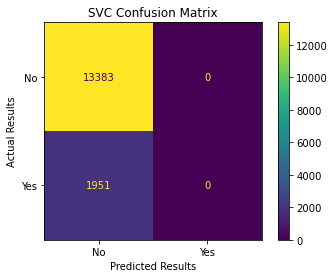

In [629]:
cm = confusion_matrix(y_test,y_pred_svc1)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes'])
cmd_obj.plot()
cmd_obj.ax_.set(title='SVC Confusion Matrix', 
                xlabel='Predicted Results', 
                ylabel='Actual Results')
plt.show()

df1['Model']=['SVC']
df1['Train Time']= [svc_rt]
df1['Test Accuracy'] = [metrics.accuracy_score(y_test, y_pred_svc1)]
df1['Test Recall']= [metrics.recall_score(y_test, y_pred_svc1)]
df1['Test Precision']= [metrics.precision_score(y_test, y_pred_svc1)]
gs_model_stats=gs_model_stats.append(df1)

Best Paramaters: {'max_depth': 6}
Best Score - Decision Tree: 0.874583997187407
DecisionTreeClassifier(max_depth=6)


[Text(984.164835164835, 1514.3142857142857, 'emp.var.rate <= -0.65\ngini = 0.221\nsamples = 15333\nvalue = [13398, 1935]\nclass = No'),
 Text(528.8736263736263, 1281.3428571428572, 'cons.conf.idx <= -43.5\ngini = 0.381\nsamples = 5687\nvalue = [4231, 1456]\nclass = No'),
 Text(252.9395604395604, 1048.3714285714286, 'cons.conf.idx <= -48.3\ngini = 0.248\nsamples = 3600\nvalue = [3077, 523]\nclass = No'),
 Text(137.96703296703296, 815.4, 'day_of_week_mon <= 0.5\ngini = 0.492\nsamples = 285\nvalue = [160, 125]\nclass = No'),
 Text(73.58241758241758, 582.4285714285713, 'previous <= 1.5\ngini = 0.5\nsamples = 214\nvalue = [109, 105]\nclass = No'),
 Text(36.79120879120879, 349.4571428571428, 'age <= 37.5\ngini = 0.497\nsamples = 181\nvalue = [98, 83]\nclass = No'),
 Text(18.395604395604394, 116.48571428571427, 'gini = 0.499\nsamples = 109\nvalue = [52, 57]\nclass = Yes'),
 Text(55.18681318681318, 116.48571428571427, 'gini = 0.461\nsamples = 72\nvalue = [46, 26]\nclass = No'),
 Text(110.37362

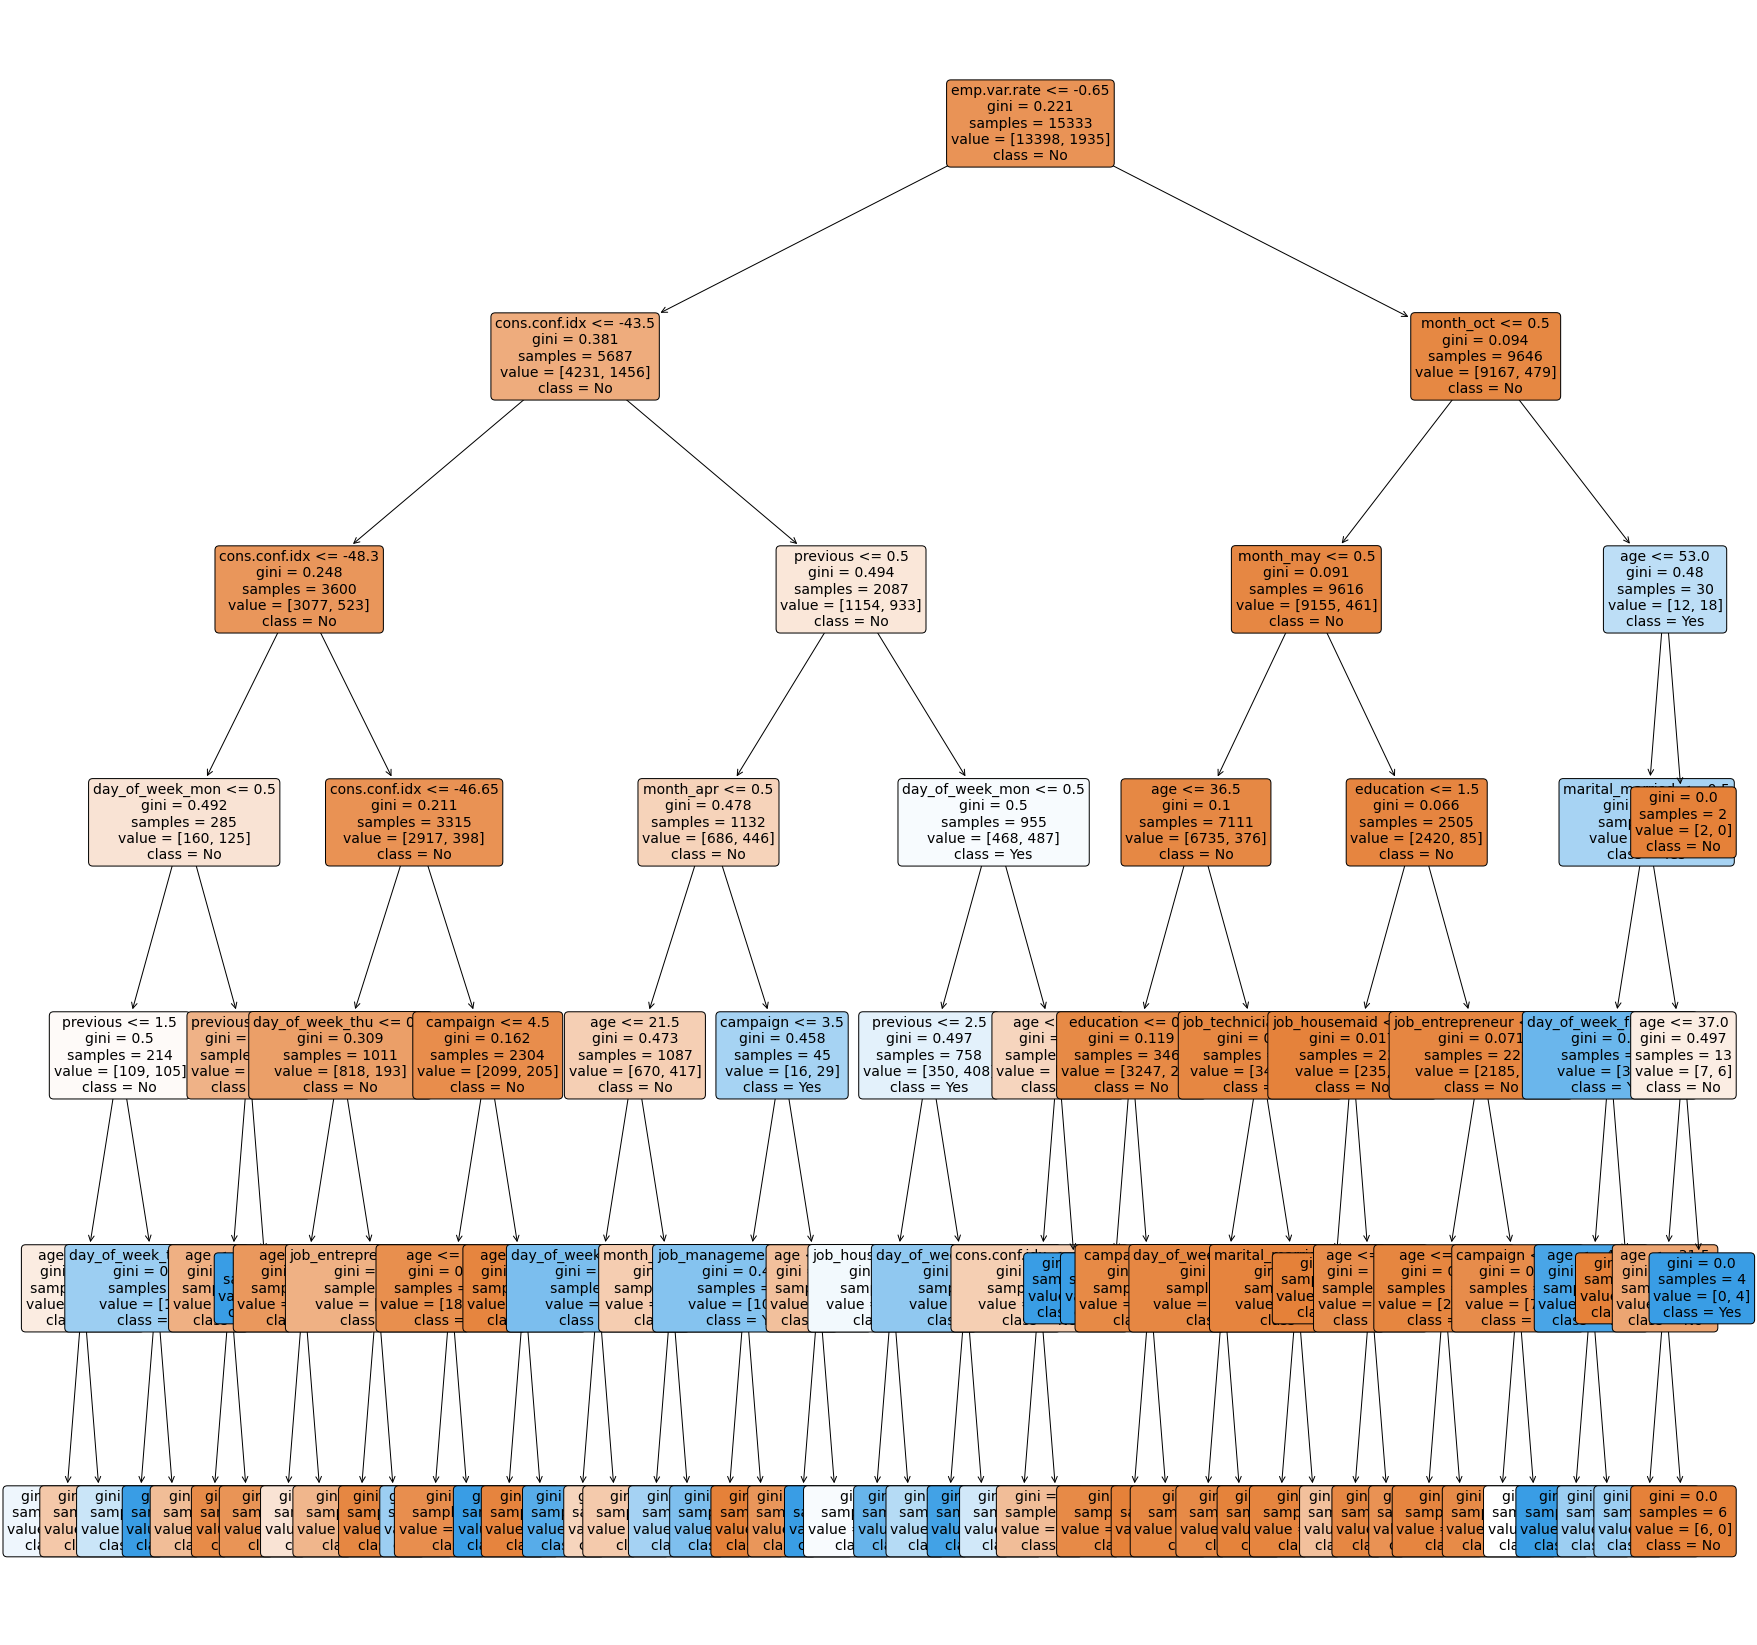

In [649]:
dt = DecisionTreeClassifier(max_depth=6).fit(X_train, y_train)
dt_train_score = dt.score(X_train,y_train)
dt_test_score = dt.score(X_test,y_test)

estimator_dt = DecisionTreeClassifier()
parameters_dt = {'max_depth':(2,3,4,5,6,7,8,9)}
grid_search_dt = GridSearchCV(
    estimator=estimator_dt,
    param_grid=parameters_dt
   ).fit(X_train, y_train)

print('Best Paramaters:' ,grid_search_dt.best_params_) 
print('Best Score - Decision Tree:', grid_search_dt.best_score_ )

mean_fit_time= grid_search_dt.cv_results_['mean_fit_time']
mean_score_time= grid_search_dt.cv_results_['mean_score_time']
n_splits  = grid_search_dt.n_splits_ #number of splits of training data
n_iter = pd.DataFrame(grid_search_dt.cv_results_).shape[0] #Iterations per split
dt_rt=np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter


dt1=grid_search_dt.fit(X_train, y_train)
y_pred_dt1 =dt1.predict(X_test)

fn=('age', 'education', 'default', 'housing', 'loan', 'campaign',
       'previous', 'emp.var.rate', 'cons.conf.idx', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed')
cn=('No', 'Yes')

print(dt)
plt.figure(figsize = (30,30))
tree.plot_tree(dt,feature_names=fn,class_names=cn,
              filled=True, 
              rounded=True, 
              fontsize=14)



In [632]:
print('Run Time',dt_rt )
print('Accuracy Score - Decision Tree - Default:', metrics.accuracy_score(y_test, y_pred_dt_default))  
print('Accuracy Score - Decision Tree - GridSearch:', metrics.accuracy_score(y_test, y_pred_dt1)) 
print('Precision - Decision Tree:', metrics.precision_score(y_test, y_pred_dt1)) 
print('Recall - Decision Tree:', metrics.recall_score(y_test, y_pred_dt1))
print('ROC Score - Decision Tree:', roc_auc_score(y_test, y_pred_dt1))

Run Time 0.8441307544708252
Accuracy Score - Decision Tree - Default: 0.8736141906873615
Accuracy Score - Decision Tree - GridSearch: 0.8767444893700274
Precision - Decision Tree: 0.5298142717497556
Recall - Decision Tree: 0.2778062532034854
ROC Score - Decision Tree: 0.6209325669364957


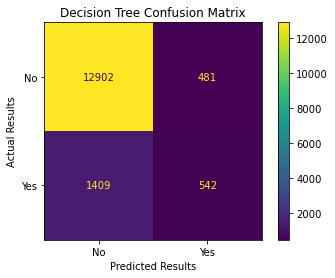

In [633]:


cm = confusion_matrix(y_test,y_pred_dt1)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes'])
cmd_obj.plot()
cmd_obj.ax_.set(title='Decision Tree Confusion Matrix', 
                xlabel='Predicted Results', 
                ylabel='Actual Results')
plt.show()

df1['Model']=['Decision Tree']
df1['Train Time']= [dt_rt]
df1['Test Accuracy'] = [metrics.accuracy_score(y_test, y_pred_dt1)]
df1['Test Recall']= [metrics.recall_score(y_test, y_pred_dt1)]
df1['Test Precision']= [metrics.precision_score(y_test, y_pred_dt1)]
gs_model_stats=gs_model_stats.append(df1)

In [634]:
gs_model_stats

,Model,Train Time,Test Accuracy,Test Recall,Test Precision
0,KNN,415.203984,0.872375,0.159918,0.495238
0,Logistic Regression,67.305900,0.870288,0.124552,0.463740
0,SVC,769.292672,0.872766,0.000000,0.000000
0,Decision Tree,0.844131,0.876744,0.277806,0.529814


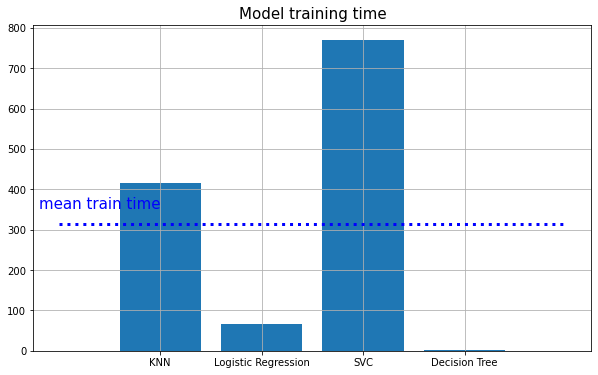

In [635]:
#ax.annotate('annotation',ha='center',va='center', xy = (0.5, 0.5), xytext=(0.51,0.51),fontsize=30)
#sns.catplot(x="Model", y="Train Time",  kind="bar", data=gs_model_stats).set(title='Model training time')
avg=gs_model_stats['Train Time'].mean()
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(gs_model_stats["Model"], gs_model_stats["Train Time"])
plt.hlines(y=avg,xmin=-1,xmax=4,ls=':',lw=3,color='blue')
ax.annotate('mean train time',ha='right',va='center', xy = (0, 0), xytext=(0,avg+50),fontsize=15,color='blue')
#plt.legend(loc=1,prop={'size':10},markerscale=2)
plt.title('Model training time',fontsize=15)
plt.grid(b=None, which='major', axis='both')

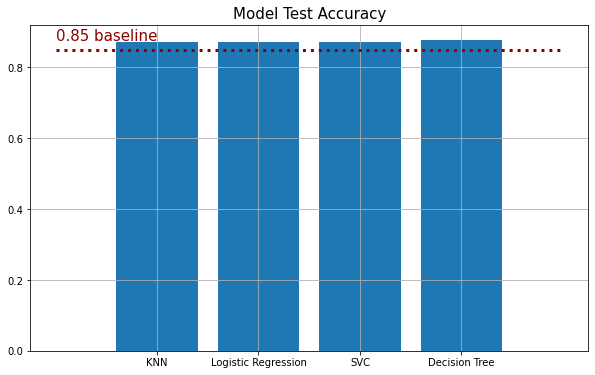

In [636]:
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(gs_model_stats["Model"], gs_model_stats["Test Accuracy"])
plt.hlines(y=0.85,xmin=-1,xmax=4,ls=':',lw=3,color='darkred')
ax.annotate('0.85 baseline',ha='right',va='center', xy = (0, 0), xytext=(0,0.89),fontsize=15,color='darkred')
plt.title('Model Test Accuracy',fontsize=15)
plt.grid(b=None, which='major', axis='both')

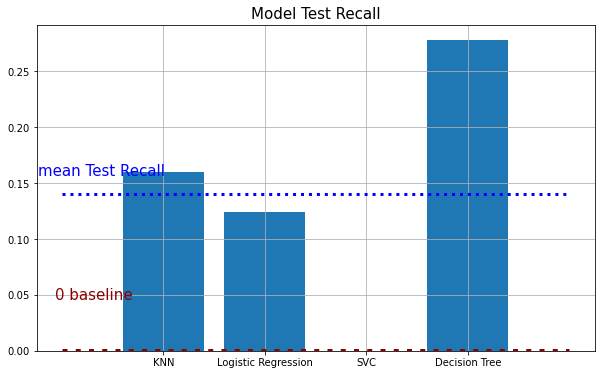

In [637]:
avg=gs_model_stats['Test Recall'].mean() 
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(gs_model_stats["Model"], gs_model_stats["Test Recall"])
plt.hlines(y=0.0,xmin=-1,xmax=4,ls=':',lw=5,color='darkred')
ax.annotate('0 baseline',ha='right',va='center', xy = (0, 0), xytext=(-.30,0.05),fontsize=15,color='darkred')
plt.hlines(y=avg,xmin=-1,xmax=4,ls=':',lw=3,color='blue')
ax.annotate('mean Test Recall',ha='right',va='center', xy = (0, 0), xytext=(.02,avg+.02),fontsize=15,color='blue')
plt.title('Model Test Recall',fontsize=15)
plt.grid(b=None, which='major', axis='both')

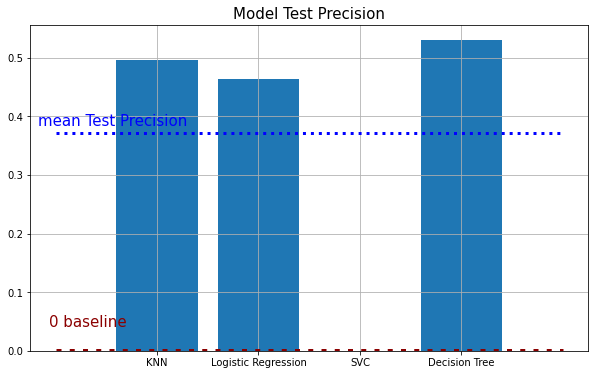

In [638]:
avg=gs_model_stats['Test Precision'].mean() 
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(gs_model_stats["Model"], gs_model_stats["Test Precision"])
plt.hlines(y=0.0,xmin=-1,xmax=4,ls=':',lw=5,color='darkred')
ax.annotate('0 baseline',ha='right',va='center', xy = (0, 0), xytext=(-.30,0.05),fontsize=15,color='darkred')
plt.hlines(y=avg,xmin=-1,xmax=4,ls=':',lw=3,color='blue')
ax.annotate('mean Test Precision',ha='right',va='center', xy = (0, 0), xytext=(.3,avg+.02),fontsize=15,color='blue')
plt.title('Model Test Precision',fontsize=15)
plt.grid(b=None, which='major', axis='both')

##### Questions